In [1]:
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from collections import Counter
from tqdm import tqdm

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [4]:
default_dtype = torch.float32

torch.set_default_dtype(default_dtype)

In [5]:
with open('names.txt', 'r') as file:
    words = file.read().splitlines()

In [6]:
def bigrams(words):
    for w in words:
        chs = ['.'] + list(w) + ['.']
        for c1, c2 in zip(chs, chs[1:]):
            yield c1, c2

In [7]:
data = sorted(Counter(sorted(bigrams(words))).items(), key=lambda kv: kv[1], reverse=True)

In [8]:
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
n = len(itos)

In [9]:
N = torch.zeros((n, n), dtype=torch.int32, device='cpu')

In [10]:
for c1, c2 in bigrams(words):
    i1 = stoi[c1]
    i2 = stoi[c2]
    N[i1, i2] += 1

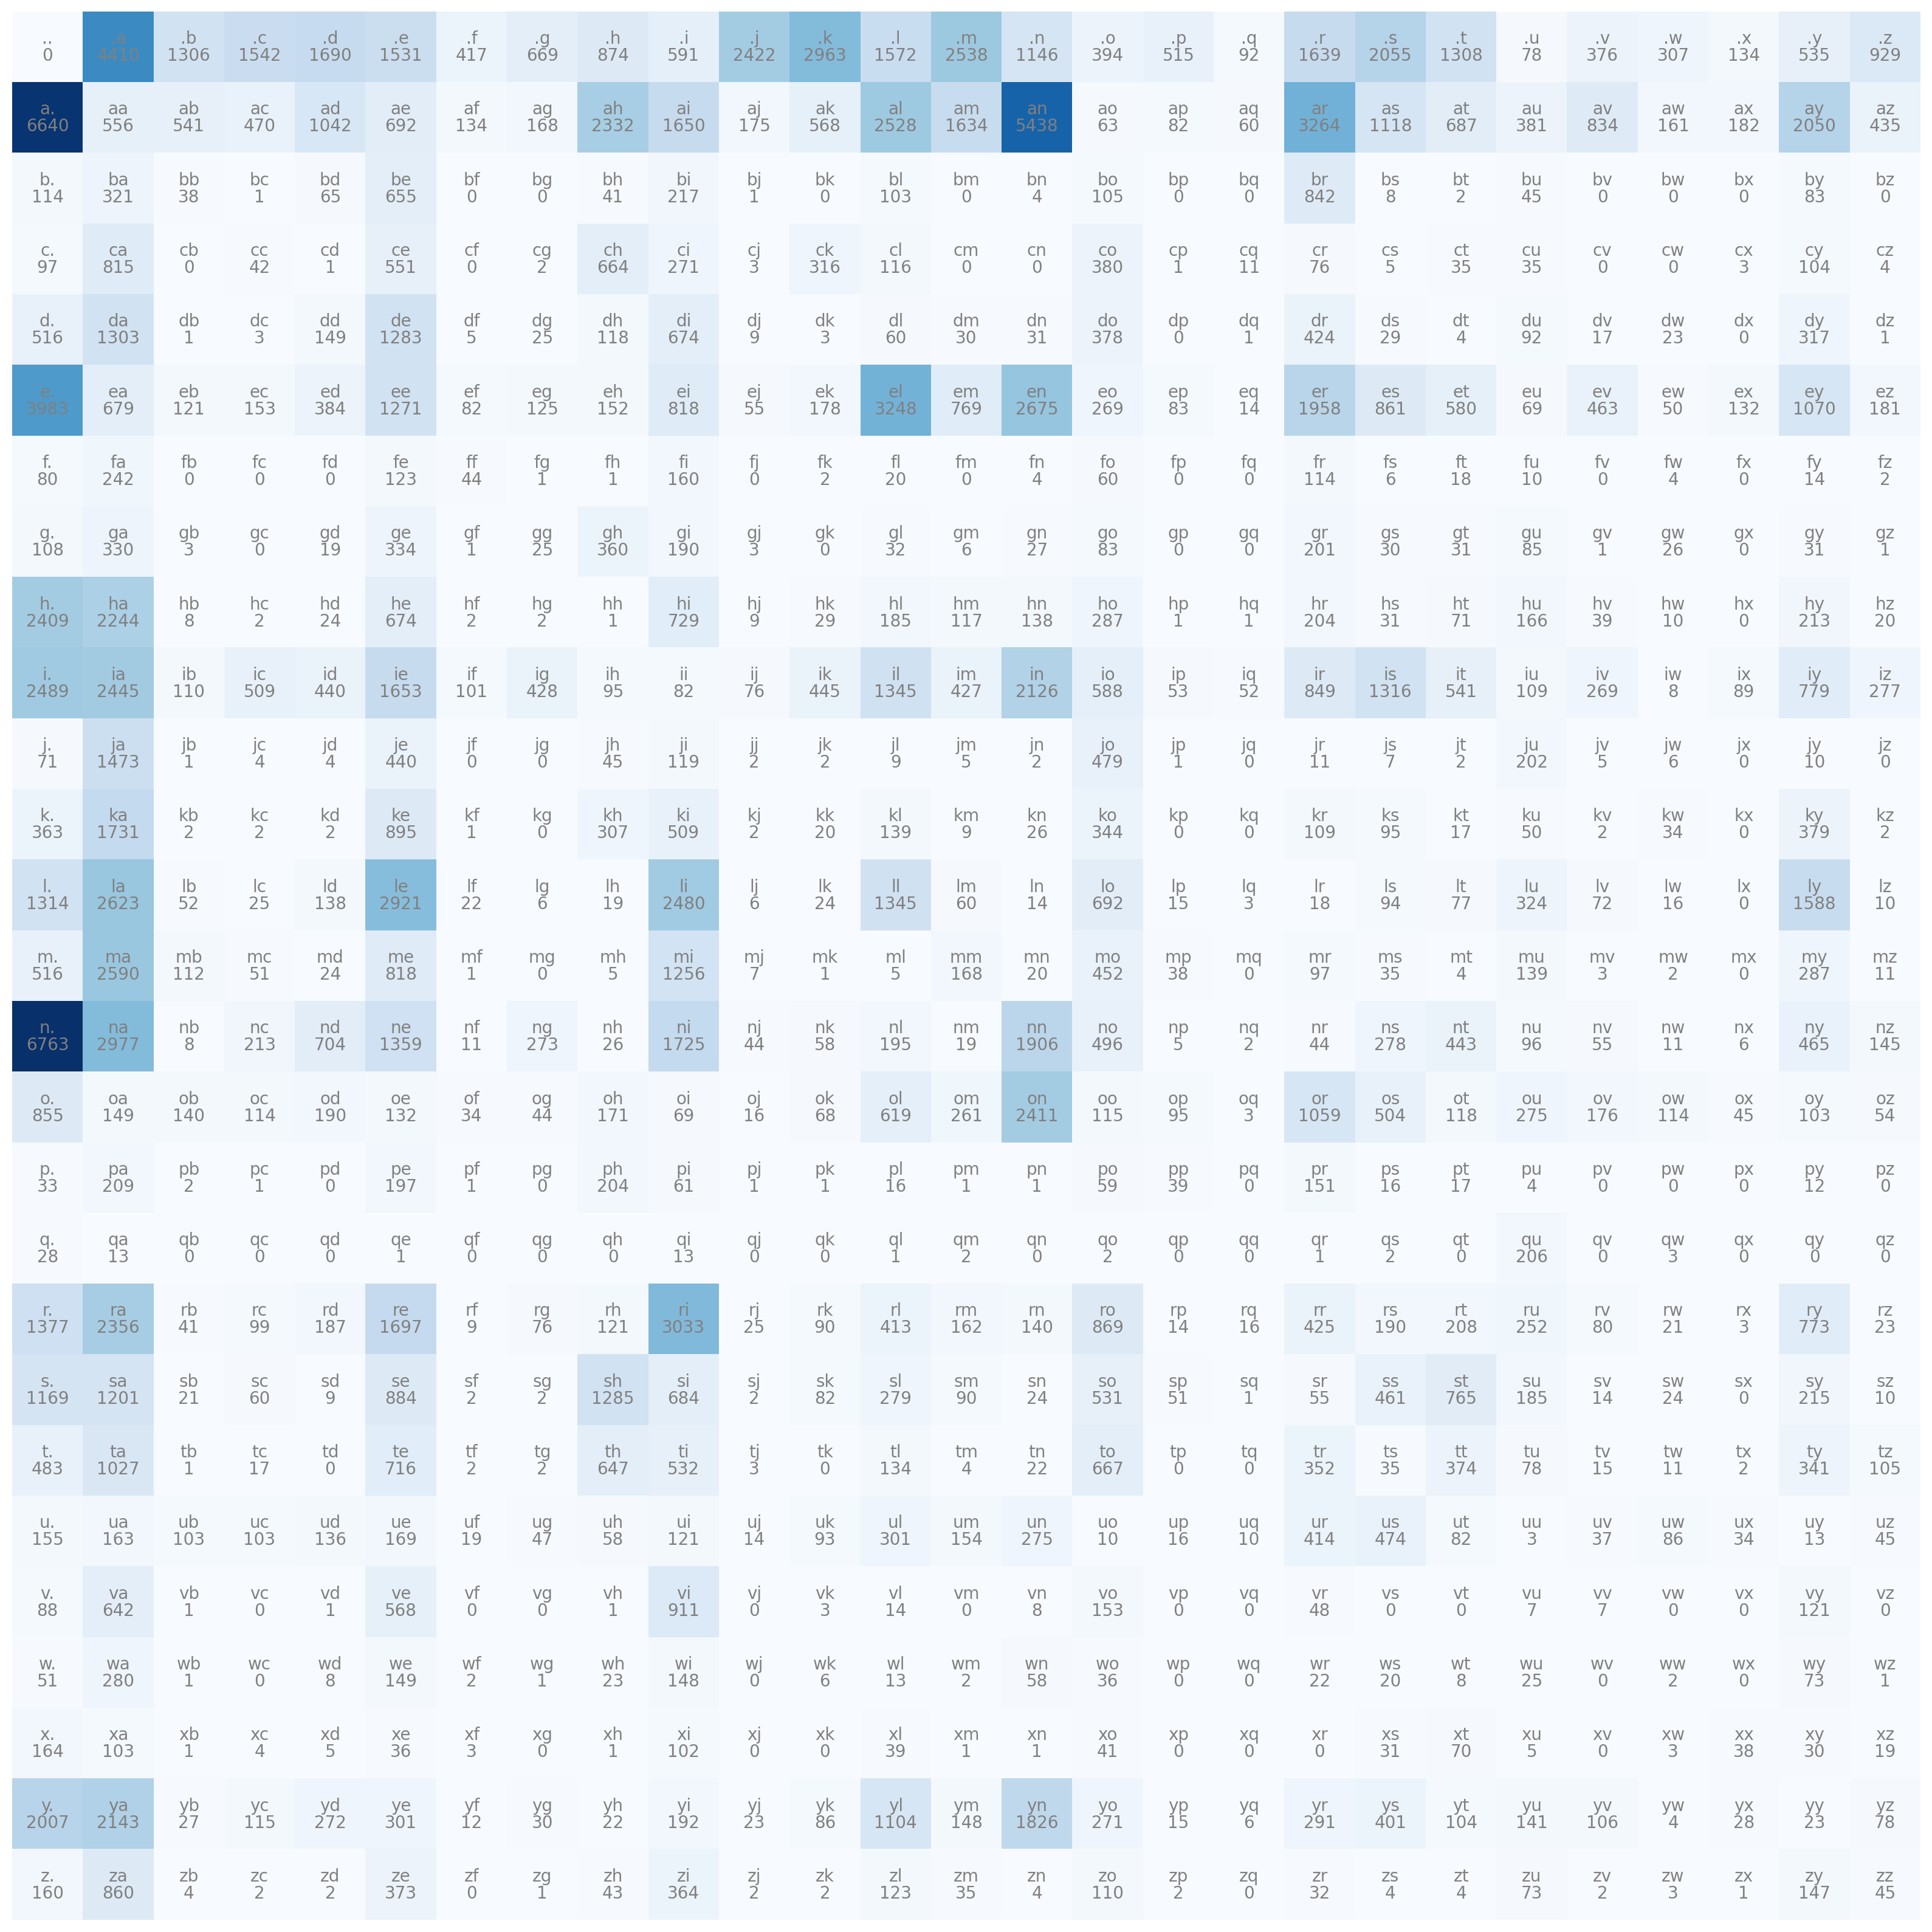

In [11]:
fig, ax = plt.subplots(figsize=(16, 16), dpi=200)
ax.imshow(N, cmap='Blues')

for i in range(n):
    for j in range(n):
        chstr = itos[i] + itos[j]
        ax.text(j, i, chstr, ha="center", va="bottom", color="gray")
        ax.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
ax.axis("off")
fig.tight_layout()

In [12]:
p = N[0].float()
p /= p.sum()
g = torch.Generator(device='cpu').manual_seed(42)

In [13]:
P = N.float()
P /= P.sum(axis=1, keepdim=True)

In [14]:
def makeone():
    ix = 0
    s = ''
    while True:
        #p = N[ix].float()
        #p /= p.sum()
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        s += itos[ix]
    return s

Now want to evaluate the model. The idea is to calculate the likelihood of the dataset given the model parameters.

In [15]:
ll = 0
n = 0
bestword = ''
bestll = -float('inf')
for word in words:
    chs = ['.'] + list(word) + ['.']
    wordll = 0
    for c1, c2 in zip(chs, chs[1:]):
        i1, i2 = stoi[c1], stoi[c2]
        lp = torch.log(P[i1, i2])
        ll += lp
        wordll += lp
        n += 1
    if wordll > bestll:
        bestll = wordll
        bestword = word
print(bestword, bestll)
nnll = -ll/n
print(nnll)

an tensor(-4.8094, device='cpu')
tensor(2.4541, device='cpu')


Create a dataset. We do this by turning character indices into one hot vector. The first character in a bigram is an $x$, the second character is a $y$.

In [16]:
xs = []
ys = []
for word in words:
    chs = ['.'] + list(word) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        i1 = stoi[c1]
        i2 = stoi[c2]
        xs.append(i1)
        ys.append(i2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [17]:
xenc = F.one_hot(xs, 27).to(default_dtype)

In [18]:
g = torch.Generator(device='cuda').manual_seed(2147483647)
W = torch.randn(27, 27, generator=g, requires_grad=True)

In [19]:
# we can jump straight to a perfect set of weights
# W = torch.log(P+0.0000000001).cuda(); W.requires_grad = True

In [20]:
t = time.time()
print(f"{'epoch':>6} {'loss':>10} {'time,s':>7}")
for i in range(100000):
    logits = xenc @ W # log-counts
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(len(xs)), ys].log().mean()# + 20*(W**2).mean()
    if (i+1)%1000 == 1:
        tt = time.time()
        print(f"{i+1:6} {loss.data.item():10.5f} {tt-t:>7.2f}")
        t = tt

    W.grad = None # zero out the gradients
    loss.backward()
    W.data += -1*W.grad

 epoch       loss  time,s
     1    3.71092    0.71
  1001    2.56753    1.54
  2001    2.50814    1.57
  3001    2.48853    1.56
  4001    2.47866    1.54
  5001    2.47278    1.54
  6001    2.46899    1.54
  7001    2.46641    1.54
  8001    2.46458    1.57
  9001    2.46321    1.56
 10001    2.46215    1.56
 11001    2.46130    1.55
 12001    2.46061    1.55
 13001    2.46003    1.56
 14001    2.45954    1.56
 15001    2.45912    1.55
 16001    2.45876    1.55
 17001    2.45844    1.55
 18001    2.45816    1.55
 19001    2.45791    1.55
 20001    2.45769    1.55
 21001    2.45749    1.55
 22001    2.45731    1.54
 23001    2.45714    1.56
 24001    2.45699    1.56
 25001    2.45686    1.55
 26001    2.45673    1.55
 27001    2.45661    1.55
 28001    2.45651    1.55
 29001    2.45641    1.54
 30001    2.45632    1.54
 31001    2.45623    1.53
 32001    2.45615    1.54
 33001    2.45608    1.53
 34001    2.45601    1.54
 35001    2.45594    1.53
 36001    2.45588    1.54
 37001    2.

KeyboardInterrupt: 

sample from the net

In [ ]:
i = 0

In [ ]:
w = ''
while True:
    xenc = F.one_hot(torch.tensor([i]), 27).float()

    logits = xenc @ W
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)

    i = torch.multinomial(probs, num_samples=1, replacement=True).item()

    if i == 0:
        break
    
    w += itos[i]
print(w)